# Fase 1 | Avance de Proyecto
---

**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC5044.10 - Operaciones de aprendizaje automático**

Tecnológico de Monterrey

**Fase 1** - Procesamiento y Modelado Inicial

**Fecha de entrega** - 12 de octubre del 2025

---

**Equipo 11**

|  NOMBRE COMPLETO                        |     MATRÍCULA     |
| :-------------------------------------: |:-----------------:|
| Ramiro González Carrillo              |  A01795565        |
| Emiliano Saucedo Arriola              |  A01659258        |
| Óscar Benjamín Zacarías Villegas      |  A01797160        |
| Luis Carlos Alberto Espinosa Alvarado |  A00816016        |

## Contexto del Dataset: Power Consumption of Tetouan City
---

Este dataset es sobre el consumo energetico de tres diferentes redes de distribucion de la ciudad Tetouan, localizada en el norte de Marruecos.

| Nombre de la Variable         | Rol          | Tipo     | Descripción                                              | Unidades          | Valores Faltantes |
|--------------------------------|--------------|----------|----------------------------------------------------------|-------------------|-------------------|
| DateTime                       | Característica | Fecha   | Cada diez minutos                                        | -                 | no                |
| Temperature                    | Característica | Continua| Temperatura meteorológica de la ciudad de Tetuán         | -                 | no                |
| Humidity                       | Característica | Continua| Humedad meteorológica de la ciudad de Tetuán             | -                 | no                |
| Wind Speed                     | Característica | Continua| Velocidad del viento de la ciudad de Tetuán              | -                 | no                |
| general diffuse flows          | Característica | Continua| Flujos difusos generales                                 | -                 | no                |
| diffuse flows                  | Característica | Continua| Flujos difusos                                           | -                 | no                |
| Zone 1 Power Consumption       | Objetivo      | Continua| Consumo de energía de la zona 1 de la ciudad de Tetuán   | -                 | no                |
| Zone 2 Power Consumption       | Objetivo      | Continua| Consumo de energía de la zona 2 de la ciudad de Tetuán   | -                 | no                |
| Zone 3 Power Consumption       | Objetivo      | Continua| Consumo de energía de la zona 3 de la ciudad de Tetuán   | -                 | no                |

---

- **Variables temporales:** DateTime
- **Variables meteorológicas:** Temperatura, humedad, velocidad del viento
- **Variables objetivo:** Consumo eléctrico de 3 zonas de la ciudad
- **Periodo:** Datos cada 10 minutos durante un año

---

## Exploración Inicial (EDA)

In [1]:
!pip install pandas numpy matplotlib seaborn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
import xgboost as xgb
import warnings

In [3]:
# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### Cargar datasets

In [4]:
# Cargar el dataset
original_df = pd.read_csv('/Users/Luis Carlos/Documents/GitHub/Equipo11-MLOps/data/raw/power_tetouan_city_original.csv')
modified_df = pd.read_csv('/Users/Luis Carlos/Documents/GitHub/Equipo11-MLOps/data/raw/power_tetouan_city_modified.csv')

print(f"\n• Dataset Original cargado: {original_df.shape}")
print(f"• Dataset Modificado cargado: {modified_df.shape}")


• Dataset Original cargado: (52416, 9)
• Dataset Modificado cargado: (53464, 10)


### Exploración rápida: Dataset Modificado

#### DATASET MODIFICADO - PRIMERAS 5 FILAS

In [5]:
modified_df.head()
# print(modified_df.head())

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,NaN,34055.6962,16128.87538,20240.96386,624
1,1/1/2017 0:10,6.414,74.5,0.083,0.07,0.085,29814.68354,19375.07599,20131.08434,811
2,1/1/2017 0:20,6.313,74.5,0.08,0.062,0.1,29128.10127,19006.68693,19668.43373,unknown
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,bad
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.6962,17872.34043,18442.40964,879


#### DATASET MODIFICADO - ÚLTIMAS 5 FILAS

In [6]:
modified_df.tail()
# print(modified_df.tail())

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
53459,10/25/2017 4:10,17.95,89.0,4.916,0.059,0.185,24672.21007,15834.0249,10662.12766,638
53460,12/3/2017 16:00,14.43,75.6,0.082,60.16,61.03,26950.57034,21437.25069,9605.762305,472
53461,3/1/2017 15:50,21.59,54.67,0.086,516.0,357.9,32372.42553,20465.85366,15996.77419,bad
53462,7/22/2017 3:00,27.65,27.18,4.904,0.113,?,29189.10299,19830.37975,25361.07531,731
53463,7/8/2017 5:20,24.44,46.62,4.914,0.091,0.107,23097.40864,14620.25316,14978.41004,134


#### Información general

In [7]:
modified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53464 entries, 0 to 53463
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   DateTime                   52977 non-null  object
 1   Temperature                52880 non-null  object
 2   Humidity                   52826 non-null  object
 3   Wind Speed                 52846 non-null  object
 4   general diffuse flows      52838 non-null  object
 5   diffuse flows              52849 non-null  object
 6   Zone 1 Power Consumption   52861 non-null  object
 7   Zone 2  Power Consumption  52839 non-null  object
 8   Zone 3  Power Consumption  52889 non-null  object
 9   mixed_type_col             48162 non-null  object
dtypes: object(10)
memory usage: 4.1+ MB


#### Estadísticas descriptivas

In [8]:
modified_df.describe()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
count,52977,52880,52826,52846,52838,52849,52861,52839,52889,48162
unique,52036,5446,6291,1187,11915,11923,29720,31474,25057,1002
top,NAN,?,84.6,0.082,0.055,0.115,?,error,error,unknown
freq,21,57,182,2179,1488,1196,57,50,50,5521


### Análisis de valores faltantes

In [9]:
# Conteo de valores faltantes
missing_data = pd.DataFrame({
    'Columna': modified_df.columns,
    'Missing_Count': modified_df.isnull().sum(),
    'Missing_Percent': (modified_df.isnull().sum() / len(modified_df)) * 100
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("\nCOLUMNAS CON VALORES FALTANTES:")
if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
else:
    print("\n✓ No hay valores faltantes en el dataset modificado")


COLUMNAS CON VALORES FALTANTES:
                  Columna  Missing_Count  Missing_Percent
           mixed_type_col           5302         9.916953
                 Humidity            638         1.193326
    general diffuse flows            626         1.170881
Zone 2  Power Consumption            625         1.169011
               Wind Speed            618         1.155918
            diffuse flows            615         1.150307
 Zone 1 Power Consumption            603         1.127862
              Temperature            584         1.092324
Zone 3  Power Consumption            575         1.075490
                 DateTime            487         0.910893


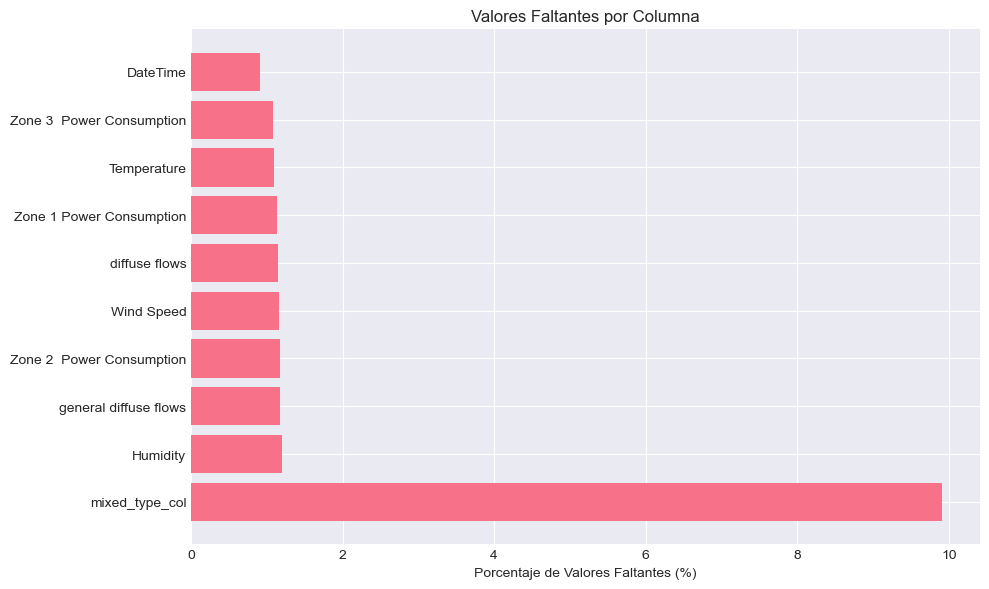

In [10]:
# Visualización de valores faltantes
plt.figure(figsize=(10, 6))
plt.barh(missing_data['Columna'], missing_data['Missing_Percent'])
plt.xlabel('Porcentaje de Valores Faltantes (%)')
plt.title('Valores Faltantes por Columna')
plt.tight_layout()
plt.show()

#### Análisis de duplicados

In [11]:
duplicados_totales = modified_df.duplicated().sum()
print(f"\nFilas completamente duplicadas: {duplicados_totales}")

# Verificar duplicados temporales
columnas_fecha = [col for col in modified_df.columns if 'date' in col.lower() or 'time' in col.lower()]
if columnas_fecha:
    for col in columnas_fecha:
        duplicados_fecha = modified_df[col].duplicated().sum()
        print(f"Timestamps duplicados en '{col}': {duplicados_fecha}")


Filas completamente duplicadas: 6
Timestamps duplicados en 'DateTime': 1427


### Comparación Dimensional: Original vs. Modificado

In [12]:
print(f"Original:    {original_df.shape[0]:,} filas x {original_df.shape[1]} columnas")
print(f"Modificado:  {modified_df.shape[0]:,} filas x {modified_df.shape[1]} columnas")
print(f"Diferencia:  {original_df.shape[0] - modified_df.shape[0]:,} filas")

Original:    52,416 filas x 9 columnas
Modificado:  53,464 filas x 10 columnas
Diferencia:  -1,048 filas


## Análisis de tipos de datos

### Tipos de datos

In [13]:
print("\nTipos de datos actuales:")
print(modified_df.dtypes)


Tipos de datos actuales:
DateTime                     object
Temperature                  object
Humidity                     object
Wind Speed                   object
general diffuse flows        object
diffuse flows                object
Zone 1 Power Consumption     object
Zone 2  Power Consumption    object
Zone 3  Power Consumption    object
mixed_type_col               object
dtype: object


In [14]:

columnas_numericas = [col for col in modified_df.columns 
                      if col not in ['DateTime', 'mixed_type_col']]

valores_invalidos_encontrados = {}
for col in columnas_numericas:
    # Identificar valores no númericos en columnas numéricas
    temp = pd.to_numeric(modified_df[col], errors='coerce')
    valores_problema = modified_df[col][temp.isna() & modified_df[col].notna()]
    
    if len(valores_problema) > 0:
        valores_unicos = valores_problema.unique()
        valores_invalidos_encontrados[col] = len(valores_problema)
        print(f"\n• {col}:")
        print(f"   Total de valores no numéricos: {len(valores_problema)}")
        print(f"   Valores únicos encontrados: {valores_unicos[:15]}")


• Temperature:
   Total de valores no numéricos: 207
   Valores únicos encontrados: ['invalid' 'error' '?' ' NAN ' ' n/a ' ' null ' ' INVALID ' ' ? '
 ' ERROR ']

• Humidity:
   Total de valores no numéricos: 197
   Valores únicos encontrados: ['error' 'invalid' '?' ' INVALID ' ' NAN ' ' ? ' ' null ' ' ERROR '
 ' n/a ']

• Wind Speed:
   Total de valores no numéricos: 183
   Valores únicos encontrados: ['error' '?' ' NAN ' 'invalid' ' INVALID ' ' ? ' ' ERROR ' ' n/a '
 ' null ']

• general diffuse flows:
   Total de valores no numéricos: 198
   Valores únicos encontrados: ['error' '?' ' INVALID ' ' ERROR ' ' ? ' 'invalid' ' NAN ' ' null '
 ' n/a ']

• diffuse flows:
   Total de valores no numéricos: 192
   Valores únicos encontrados: [' NAN ' ' null ' 'error' '?' ' ? ' 'invalid' ' n/a ' ' ERROR '
 ' INVALID ']

• Zone 1 Power Consumption:
   Total de valores no numéricos: 198
   Valores únicos encontrados: [' NAN ' 'invalid' 'error' '?' ' ERROR ' ' INVALID ' ' null ' ' ? ']

• Zone 2 

In [15]:
# Análisis de la columna 'mixed_type_col' (columna 'extra')
print(f"\nValores únicos en mixed_type_col: {modified_df['mixed_type_col'].nunique()}")
print(f"Valores faltantes: {modified_df['mixed_type_col'].isna().sum()}")
print(f"\nPrimeros 10 valores más frecuentes:")
print(modified_df['mixed_type_col'].value_counts().head(10))

# No existe, parece que no aporta mucha información :. eliminar


Valores únicos en mixed_type_col: 1002
Valores faltantes: 5302

Primeros 10 valores más frecuentes:
mixed_type_col
unknown    5521
bad        5263
9            58
85           57
730          57
161          54
756          54
380          54
164          53
409          53
Name: count, dtype: int64


In [16]:
# Timestamps duplicados
duplicados_dt = modified_df[modified_df.duplicated(subset=['DateTime'], keep=False)]
print(f"\nTotal de filas con timestamps duplicados: {len(duplicados_dt)}")

if len(duplicados_dt) > 0:
    print("\nEjemplo de timestamps duplicados (primeras 6 filas):")
    print(duplicados_dt.sort_values('DateTime').head(6)[['DateTime', 'Temperature', 'Humidity']])

# Timestamps faltantes
filas_sin_datetime = modified_df['DateTime'].isna().sum()
print(f"\nFilas sin DateTime: {filas_sin_datetime}")

# Verificar continuidad temporal
df_temp = modified_df[modified_df['DateTime'].notna()].copy()
df_temp['DateTime_parsed'] = pd.to_datetime(df_temp['DateTime'], format='%m/%d/%Y %H:%M', errors='coerce')

filas_fecha_invalida = df_temp['DateTime_parsed'].isna().sum()
print(f"Filas con formato de fecha inválido: {filas_fecha_invalida}")

print(f"   - {filas_sin_datetime} filas sin timestamp (inútiles para series temporales)")
print(f"   - {filas_fecha_invalida} filas con fechas imparsables")
print(f"   - {len(duplicados_dt)} filas con timestamps duplicados")

# Decisión: Eliminar filas sin timestamp, fechas inválidas y duplicados


Total de filas con timestamps duplicados: 2350

Ejemplo de timestamps duplicados (primeras 6 filas):
                 DateTime Temperature Humidity
50511   12/17/2017 18:30        15.83     72.8
53066   12/17/2017 18:30        15.83     72.8
53099      2/2/2017 5:30        6.876     75.0
4641       2/2/2017 5:30          NaN    75.0 
26030    6/30/2017 18:20        29.09    39.79
52615    6/30/2017 18:20        29.09    39.79

Filas sin DateTime: 487
Filas con formato de fecha inválido: 2676
   - 487 filas sin timestamp (inútiles para series temporales)
   - 2676 filas con fechas imparsables
   - 2350 filas con timestamps duplicados


### Cálculo de IQR con base en el Dataset Original

In [17]:
rangos_calculados = {}
for col in columnas_numericas:
    # Convertir a numérico y calcular estadísticas del original
    valores_orig = pd.to_numeric(original_df[col], errors='coerce')
    
    q1 = valores_orig.quantile(0.25)
    q3 = valores_orig.quantile(0.75)
    iqr = q3 - q1
    
    # Límites usando 3*IQR (muy permisivo, solo outliers extremos)
    lower_fence = q1 - 3 * iqr
    upper_fence = q3 + 3 * iqr
    
    # No permitir valores negativos donde no tiene sentido
    if lower_fence < 0:
        lower_fence = 0
    
    rangos_calculados[col] = (lower_fence, upper_fence)
    
    print(f"• {col}:")
    print(f"  Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}")
    print(f"  → Rango válido calculado: [{lower_fence:.2f}, {upper_fence:.2f}]")

• Temperature:
  Q1=14.41, Q3=22.89, IQR=8.48
  → Rango válido calculado: [0.00, 48.33]
• Humidity:
  Q1=58.31, Q3=81.40, IQR=23.09
  → Rango válido calculado: [0.00, 150.67]
• Wind Speed:
  Q1=0.08, Q3=4.92, IQR=4.84
  → Rango válido calculado: [0.00, 19.43]
• general diffuse flows:
  Q1=0.06, Q3=319.60, IQR=319.54
  → Rango válido calculado: [0.00, 1278.21]
• diffuse flows:
  Q1=0.12, Q3=101.00, IQR=100.88
  → Rango válido calculado: [0.00, 403.63]
• Zone 1 Power Consumption:
  Q1=26310.67, Q3=37309.02, IQR=10998.35
  → Rango válido calculado: [0.00, 70304.07]
• Zone 2  Power Consumption:
  Q1=16980.77, Q3=24713.72, IQR=7732.95
  → Rango válido calculado: [0.00, 47912.57]
• Zone 3  Power Consumption:
  Q1=13129.33, Q3=21624.10, IQR=8494.77
  → Rango válido calculado: [0.00, 47108.42]


### Identificación de Outliers (Dataset Modificado)

In [18]:
df_mod_numeric = modified_df.copy()
for col in columnas_numericas:
    if col in df_mod_numeric.columns:
        df_mod_numeric[col] = pd.to_numeric(df_mod_numeric[col], errors='coerce')

outliers_detectados = {}
outliers_ejemplos = {}

print("\n🔍 Outliers extremos detectados con rangos calculados:")
print("-"*80)

for col in columnas_numericas:
    if col in rangos_calculados and col in df_mod_numeric.columns:
        min_val, max_val = rangos_calculados[col]
        outliers = ((df_mod_numeric[col] < min_val) | (df_mod_numeric[col] > max_val)) & df_mod_numeric[col].notna()
        num_outliers = outliers.sum()
        outliers_detectados[col] = num_outliers
        
        if num_outliers > 0:
            ejemplos = df_mod_numeric.loc[outliers, col].dropna().head(3).values
            outliers_ejemplos[col] = ejemplos
            print(f"  • {col}: {num_outliers} outliers")
            print(f"    Ejemplos de valores extremos: {ejemplos}")
            print()

total_outliers = sum(outliers_detectados.values())
print(f"\nTOTAL DE OUTLIERS EXTREMOS: {total_outliers}")

# Decisión: Convertir outliers a NaN para no perder filas completas



🔍 Outliers extremos detectados con rangos calculados:
--------------------------------------------------------------------------------
  • Temperature: 537 outliers
    Ejemplos de valores extremos: [642.5  974.85 317.68]

  • Humidity: 562 outliers
    Ejemplos de valores extremos: [1402.  1879.1  438.7]

  • Wind Speed: 359 outliers
    Ejemplos de valores extremos: [208.451 115.08  392.076]

  • general diffuse flows: 132 outliers
    Ejemplos de valores extremos: [ 6134.  22824.2  1323.7]

  • diffuse flows: 2011 outliers
    Ejemplos de valores extremos: [703.085 578.178 866.59 ]

  • Zone 1 Power Consumption: 274 outliers
    Ejemplos de valores extremos: [1977356.9616  1792526.58255 2166349.36705]

  • Zone 2  Power Consumption: 243 outliers
    Ejemplos de valores extremos: [ 983259.57429 1288161.7021  1129469.90895]

  • Zone 3  Power Consumption: 287 outliers
    Ejemplos de valores extremos: [1812942.65088  829497.8315   251826.50595]


TOTAL DE OUTLIERS EXTREMOS: 4405


## Limpieza de Datos

In [19]:
# Crear copia para trabajar
df_clean = modified_df.copy()

# Definir columnas numéricas
columnas_numericas = [col for col in df_clean.columns if col not in ['DateTime', 'mixed_type_col']]

### Eliminar columna `mixed_type_col`

In [20]:
df_clean = df_clean.drop(columns=['mixed_type_col'])
print(f"Columna eliminada. Ahora: {df_clean.shape[1]} columnas")

Columna eliminada. Ahora: 9 columnas


### Conversión: Valores No Numéricos → NaN

In [21]:
valores_invalidos = ['error', 'invalid', '?', 'NAN', 'n/a', 'null', 'INVALID', 
                     'ERROR', ' NAN ', ' ? ', ' ERROR ', ' INVALID ', ' n/a ', ' null ']

for col in columnas_numericas:
    df_clean[col] = df_clean[col].replace(valores_invalidos, np.nan)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print(f"Valores no numéricos convertidos a NaN en todas las columnas")

Valores no numéricos convertidos a NaN en todas las columnas


### Eliminar filas sin DateTime

In [22]:
filas_sin_datetime = df_clean['DateTime'].isna().sum()
df_clean = df_clean[df_clean['DateTime'].notna()]
print(f"{filas_sin_datetime} filas eliminadas. Ahora: {len(df_clean)} filas")

487 filas eliminadas. Ahora: 52977 filas


### Parsear y ordenar por DateTime

In [23]:
df_clean['DateTime_parsed'] = pd.to_datetime(df_clean['DateTime'], 
                                              format='%m/%d/%Y %H:%M', 
                                              errors='coerce')

filas_con_fecha_invalida = df_clean['DateTime_parsed'].isna().sum()
if filas_con_fecha_invalida > 0:
    df_clean = df_clean[df_clean['DateTime_parsed'].notna()]
    print(f"{filas_con_fecha_invalida} filas con fechas inválidas eliminadas")

df_clean = df_clean.sort_values('DateTime_parsed')
print(f"Dataset ordenado por DateTime. Ahora: {len(df_clean)} filas")

2676 filas con fechas inválidas eliminadas
Dataset ordenado por DateTime. Ahora: 50301 filas


### Eliminar duplicados de TIMESTAMP

In [24]:
duplicados_antes = df_clean.duplicated(subset=['DateTime_parsed'], keep=False).sum()
df_clean = df_clean.drop_duplicates(subset=['DateTime_parsed'], keep='first')
duplicados_eliminados = duplicados_antes - df_clean.duplicated(subset=['DateTime_parsed'], keep=False).sum()

print(f"{duplicados_eliminados} duplicados eliminados (manteniendo el primero)")
print(f"Ahora: {len(df_clean)} filas")

1832 duplicados eliminados (manteniendo el primero)
Ahora: 49385 filas


### Aplicar rangos IQR para detección de Outliers 

In [25]:
# Recalcular rangos desde el original (ya se hizo en Fase 2, aquí solo aplicamos)
rangos_calculados = {}
for col in columnas_numericas:
    valores_orig = pd.to_numeric(original_df[col], errors='coerce')
    q1 = valores_orig.quantile(0.25)
    q3 = valores_orig.quantile(0.75)
    iqr = q3 - q1
    lower_fence = max(0, q1 - 3 * iqr)
    upper_fence = q3 + 3 * iqr
    rangos_calculados[col] = (lower_fence, upper_fence)

outliers_por_columna = {}
for col, (min_val, max_val) in rangos_calculados.items():
    outliers = ((df_clean[col] < min_val) | (df_clean[col] > max_val)) & df_clean[col].notna()
    num_outliers = outliers.sum()
    outliers_por_columna[col] = num_outliers
    
    if num_outliers > 0:
        print(f"   • {col}: {num_outliers} outliers extremos → convertidos a NaN")
        df_clean.loc[outliers, col] = np.nan

print(f"\nTotal de outliers convertidos a NaN: {sum(outliers_por_columna.values())}")

   • Temperature: 495 outliers extremos → convertidos a NaN
   • Humidity: 521 outliers extremos → convertidos a NaN
   • Wind Speed: 328 outliers extremos → convertidos a NaN
   • general diffuse flows: 125 outliers extremos → convertidos a NaN
   • diffuse flows: 1875 outliers extremos → convertidos a NaN
   • Zone 1 Power Consumption: 251 outliers extremos → convertidos a NaN
   • Zone 2  Power Consumption: 227 outliers extremos → convertidos a NaN
   • Zone 3  Power Consumption: 266 outliers extremos → convertidos a NaN

Total de outliers convertidos a NaN: 4088


### Distribución de NaNs

In [26]:
nans_por_fila = df_clean[columnas_numericas].isna().sum(axis=1)

print(f"\nDistribución de NaNs por fila:")
print(f"  • 0 NaNs: {(nans_por_fila == 0).sum()} filas ({(nans_por_fila == 0).sum()/len(df_clean)*100:.1f}%)")
print(f"  • 1 NaN:  {(nans_por_fila == 1).sum()} filas ({(nans_por_fila == 1).sum()/len(df_clean)*100:.1f}%)")
print(f"  • 2 NaNs: {(nans_por_fila == 2).sum()} filas ({(nans_por_fila == 2).sum()/len(df_clean)*100:.1f}%)")
print(f"  • 3 NaNs: {(nans_por_fila == 3).sum()} filas ({(nans_por_fila == 3).sum()/len(df_clean)*100:.1f}%)")
print(f"  • 4+ NaNs: {(nans_por_fila >= 4).sum()} filas ({(nans_por_fila >= 4).sum()/len(df_clean)*100:.1f}%)")


Distribución de NaNs por fila:
  • 0 NaNs: 40192 filas (81.4%)
  • 1 NaN:  8448 filas (17.1%)
  • 2 NaNs: 710 filas (1.4%)
  • 3 NaNs: 31 filas (0.1%)
  • 4+ NaNs: 4 filas (0.0%)


In [27]:
umbral_nans = 4
filas_antes = len(df_clean)
df_clean = df_clean[nans_por_fila < umbral_nans]
filas_eliminadas = filas_antes - len(df_clean)

print(f"\n{filas_eliminadas} filas eliminadas (≥{umbral_nans} NaNs)")
print(f"Ahora: {len(df_clean)} filas")


4 filas eliminadas (≥4 NaNs)
Ahora: 49381 filas


In [28]:
# Mostrar NaNs remanentes
nans_restantes = df_clean[columnas_numericas].isna().sum()
total_nans = nans_restantes.sum()

if total_nans > 0:
    print(f"\nValores faltantes remanentes:")
    for col, count in nans_restantes.items():
        if count > 0:
            pct = (count / len(df_clean)) * 100
            print(f"  • {col}: {count} NaNs ({pct:.2f}%)")
    print(f"\n  Total de NaNs: {total_nans} ({(total_nans/(len(df_clean)*len(columnas_numericas)))*100:.2f}% del dataset)")



Valores faltantes remanentes:
  • Temperature: 1222 NaNs (2.47%)
  • Humidity: 1283 NaNs (2.60%)
  • Wind Speed: 1062 NaNs (2.15%)
  • general diffuse flows: 888 NaNs (1.80%)
  • diffuse flows: 2606 NaNs (5.28%)
  • Zone 1 Power Consumption: 991 NaNs (2.01%)
  • Zone 2  Power Consumption: 958 NaNs (1.94%)
  • Zone 3  Power Consumption: 951 NaNs (1.93%)

  Total de NaNs: 9961 (2.52% del dataset)


In [29]:
df_clean = df_clean.drop(columns=['DateTime_parsed'])
df_clean = df_clean.reset_index(drop=True)

### Validación de resultados

In [30]:
print(f"\nCOMPARACIÓN DE TAMAÑOS:")
print(f"  Modificado inicial: {modified_df.shape[0]:,} filas")
print(f"  Limpio final:       {df_clean.shape[0]:,} filas")
print(f"  Eliminadas:         {modified_df.shape[0] - df_clean.shape[0]:,} filas ({((modified_df.shape[0] - df_clean.shape[0])/modified_df.shape[0]*100):.2f}%)")

print(f"\nCOMPARACIÓN CON ORIGINAL:")
print(f"  Original:           {original_df.shape[0]:,} filas")
print(f"  Limpio:             {df_clean.shape[0]:,} filas")
print(f"  Diferencia:         {abs(df_clean.shape[0] - original_df.shape[0]):,} filas")
print(f"  Recuperación:       {(df_clean.shape[0]/original_df.shape[0]*100):.2f}%")


COMPARACIÓN DE TAMAÑOS:
  Modificado inicial: 53,464 filas
  Limpio final:       49,381 filas
  Eliminadas:         4,083 filas (7.64%)

COMPARACIÓN CON ORIGINAL:
  Original:           52,416 filas
  Limpio:             49,381 filas
  Diferencia:         3,035 filas
  Recuperación:       94.21%


In [31]:
# Validación estadística
print(f"\n📊 VALIDACIÓN ESTADÍSTICA:")
print("-"*80)
print(f"{'Variable':<30} {'Original':>12} {'Limpio':>12} {'Diff %':>10}")
print("-"*80)
desviaciones = []
for col in columnas_numericas:
    orig_mean = pd.to_numeric(original_df[col], errors='coerce').mean()
    clean_mean = df_clean[col].mean()
    diff_pct = abs(((clean_mean - orig_mean) / orig_mean) * 100)
    desviaciones.append(diff_pct)
    
    status = "OK" if diff_pct < 5 else "WARN"
    print(f"{status} {col:<28} {orig_mean:>12.2f} {clean_mean:>12.2f} {diff_pct:>9.2f}%")

print("-"*80)
print(f"Desviación promedio: {np.mean(desviaciones):.2f}%")

if np.mean(desviaciones) < 5:
    print("Las distribuciones se mantienen muy similares al original")
elif np.mean(desviaciones) < 10:
    print("Las distribuciones tienen desviación moderada")
else:
    print("Las distribuciones difieren significativamente")



📊 VALIDACIÓN ESTADÍSTICA:
--------------------------------------------------------------------------------
Variable                           Original       Limpio     Diff %
--------------------------------------------------------------------------------
OK Temperature                         18.81        18.82      0.05%
OK Humidity                            68.26        68.27      0.01%
OK Wind Speed                           1.96         1.96      0.17%
OK general diffuse flows              182.70       185.11      1.32%
WARN diffuse flows                       75.03        59.62     20.54%
OK Zone 1 Power Consumption         32344.97     32347.70      0.01%
OK Zone 2  Power Consumption        21042.51     21044.26      0.01%
OK Zone 3  Power Consumption        17835.41     17813.39      0.12%
--------------------------------------------------------------------------------
Desviación promedio: 2.78%
Las distribuciones se mantienen muy similares al original


In [32]:
# Guardar dataset limpio
df_clean.to_csv('power_consumption_cleaned.csv', index=False)
print("\nDataset limpio guardado como 'power_consumption_cleaned.csv'")


Dataset limpio guardado como 'power_consumption_cleaned.csv'


In [33]:
df_clean["DateTime"] = pd.to_datetime(df_clean["DateTime"], errors="coerce")

In [34]:
df_clean.set_index("DateTime", inplace=True)

In [35]:
df_clean.dropna(inplace=True)

### Visualización comparativa

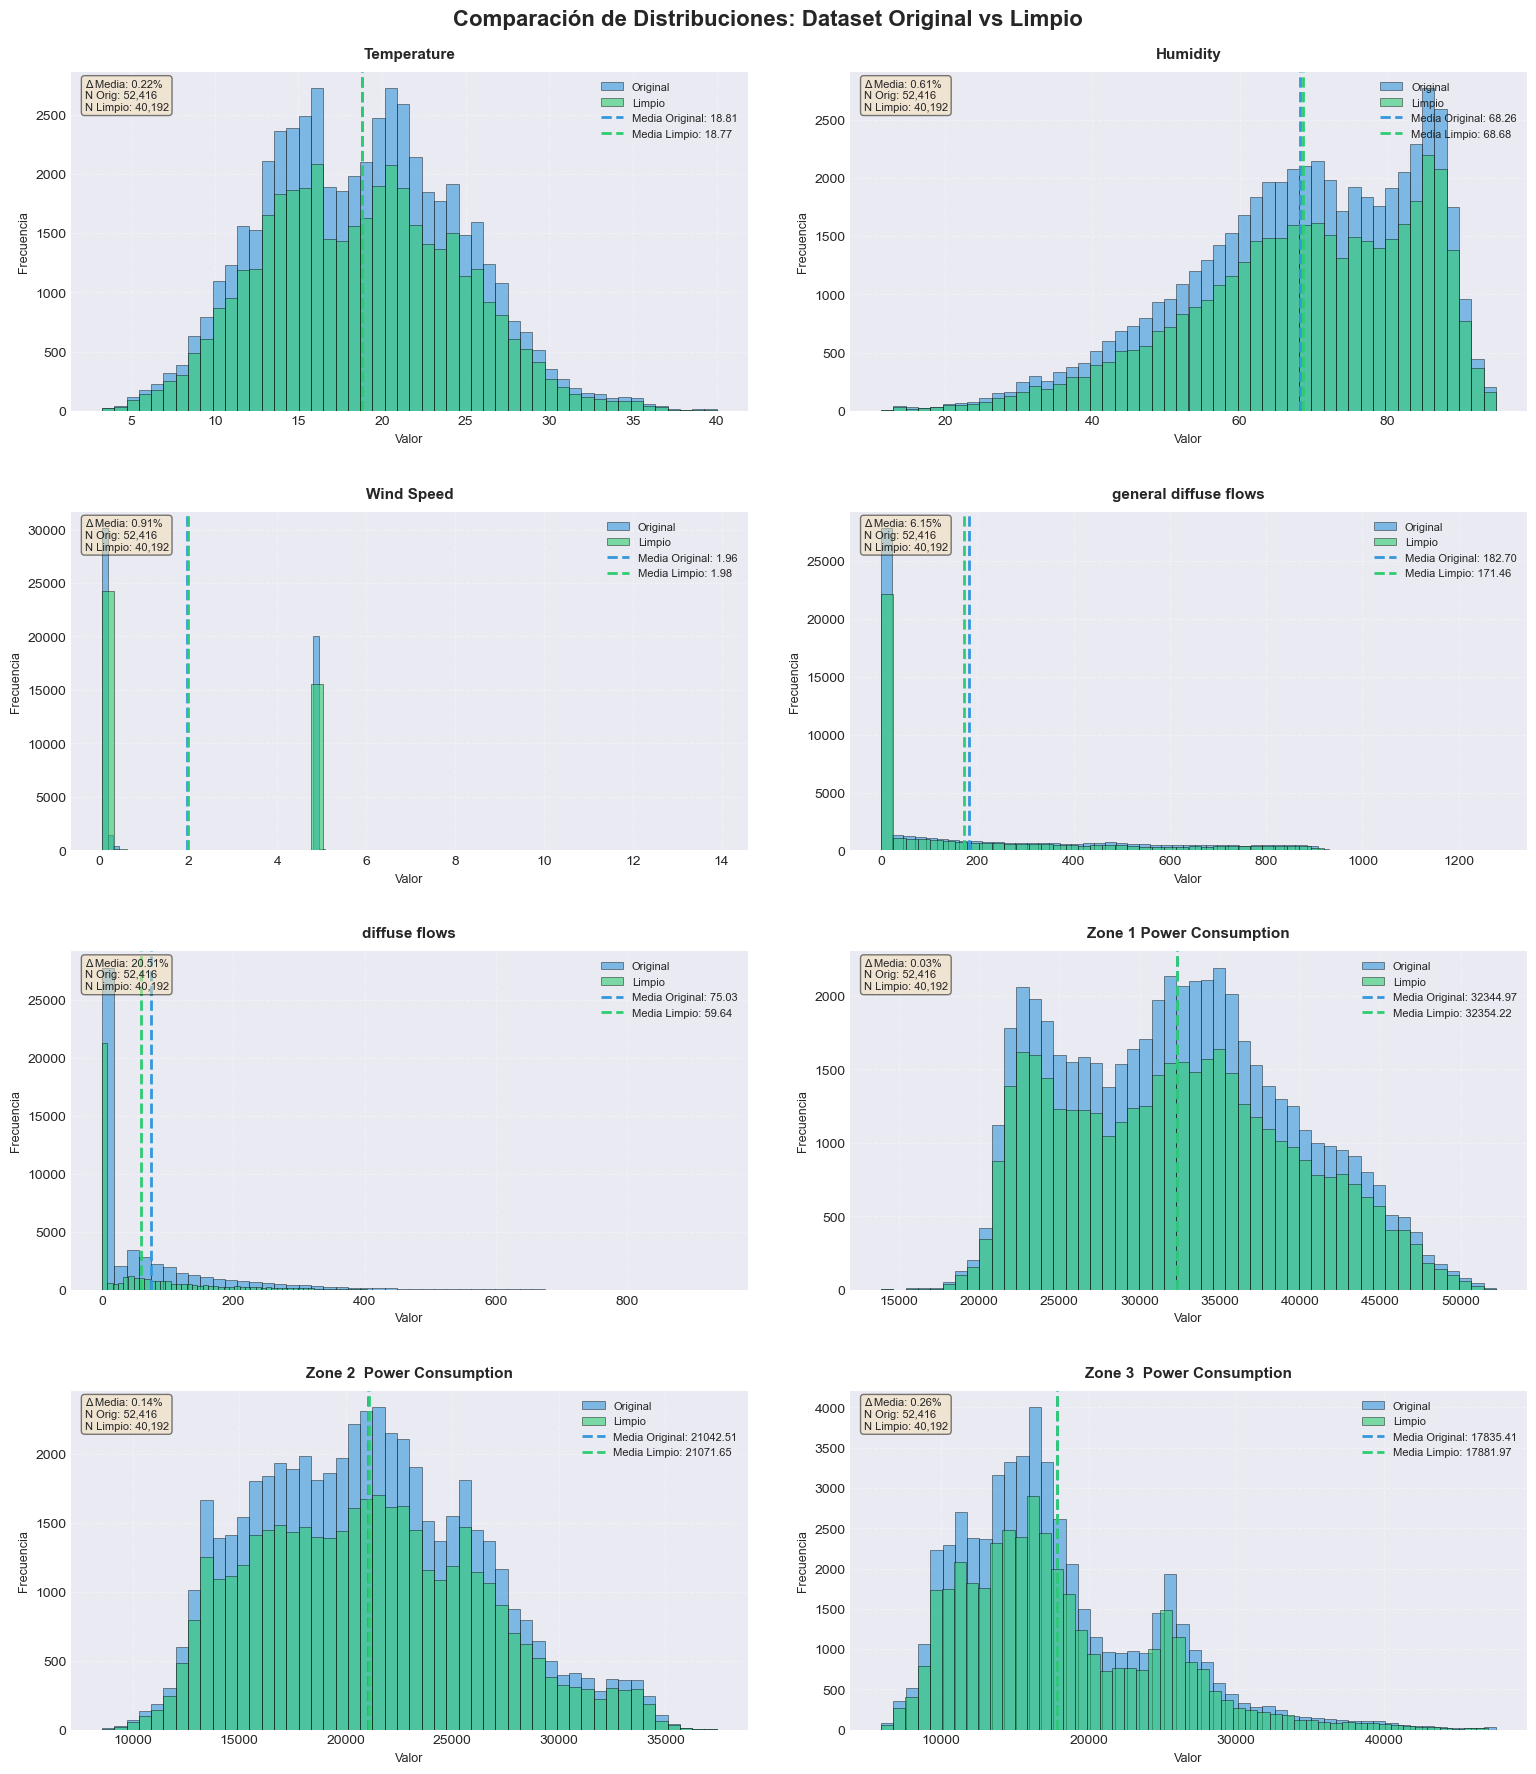

In [36]:
# Preparar datos del original
df_original_numeric = original_df.copy()
for col in columnas_numericas:
    df_original_numeric[col] = pd.to_numeric(df_original_numeric[col], errors='coerce')

# Colores
color_original = '#3498db'
color_limpio = '#2ecc71'

# GRÁFICO 1: Histogramas superpuestos
fig, axes = plt.subplots(4, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, col in enumerate(columnas_numericas):
    ax = axes[idx]
    
    datos_original = df_original_numeric[col].dropna()
    datos_limpio = df_clean[col].dropna()
    
    ax.hist(datos_original, bins=50, alpha=0.6, label='Original', 
            color=color_original, edgecolor='black', linewidth=0.5)
    ax.hist(datos_limpio, bins=50, alpha=0.6, label='Limpio', 
            color=color_limpio, edgecolor='black', linewidth=0.5)
    
    ax.axvline(datos_original.mean(), color=color_original, 
               linestyle='--', linewidth=2, label=f'Media Original: {datos_original.mean():.2f}')
    ax.axvline(datos_limpio.mean(), color=color_limpio, 
               linestyle='--', linewidth=2, label=f'Media Limpio: {datos_limpio.mean():.2f}')
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold', pad=10)
    ax.set_xlabel('Valor', fontsize=9)
    ax.set_ylabel('Frecuencia', fontsize=9)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    diff_pct = abs((datos_limpio.mean() - datos_original.mean()) / datos_original.mean() * 100)
    textstr = f'Δ Media: {diff_pct:.2f}%\nN Orig: {len(datos_original):,}\nN Limpio: {len(datos_limpio):,}'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(pad=3.0)
plt.suptitle('Comparación de Distribuciones: Dataset Original vs Limpio', 
             fontsize=16, fontweight='bold', y=0.998)
# plt.savefig('distribucion_original_vs_limpio.png', dpi=300, bbox_inches='tight')
# print("Histogramas guardados como 'distribucion_original_vs_limpio.png'")
plt.show()

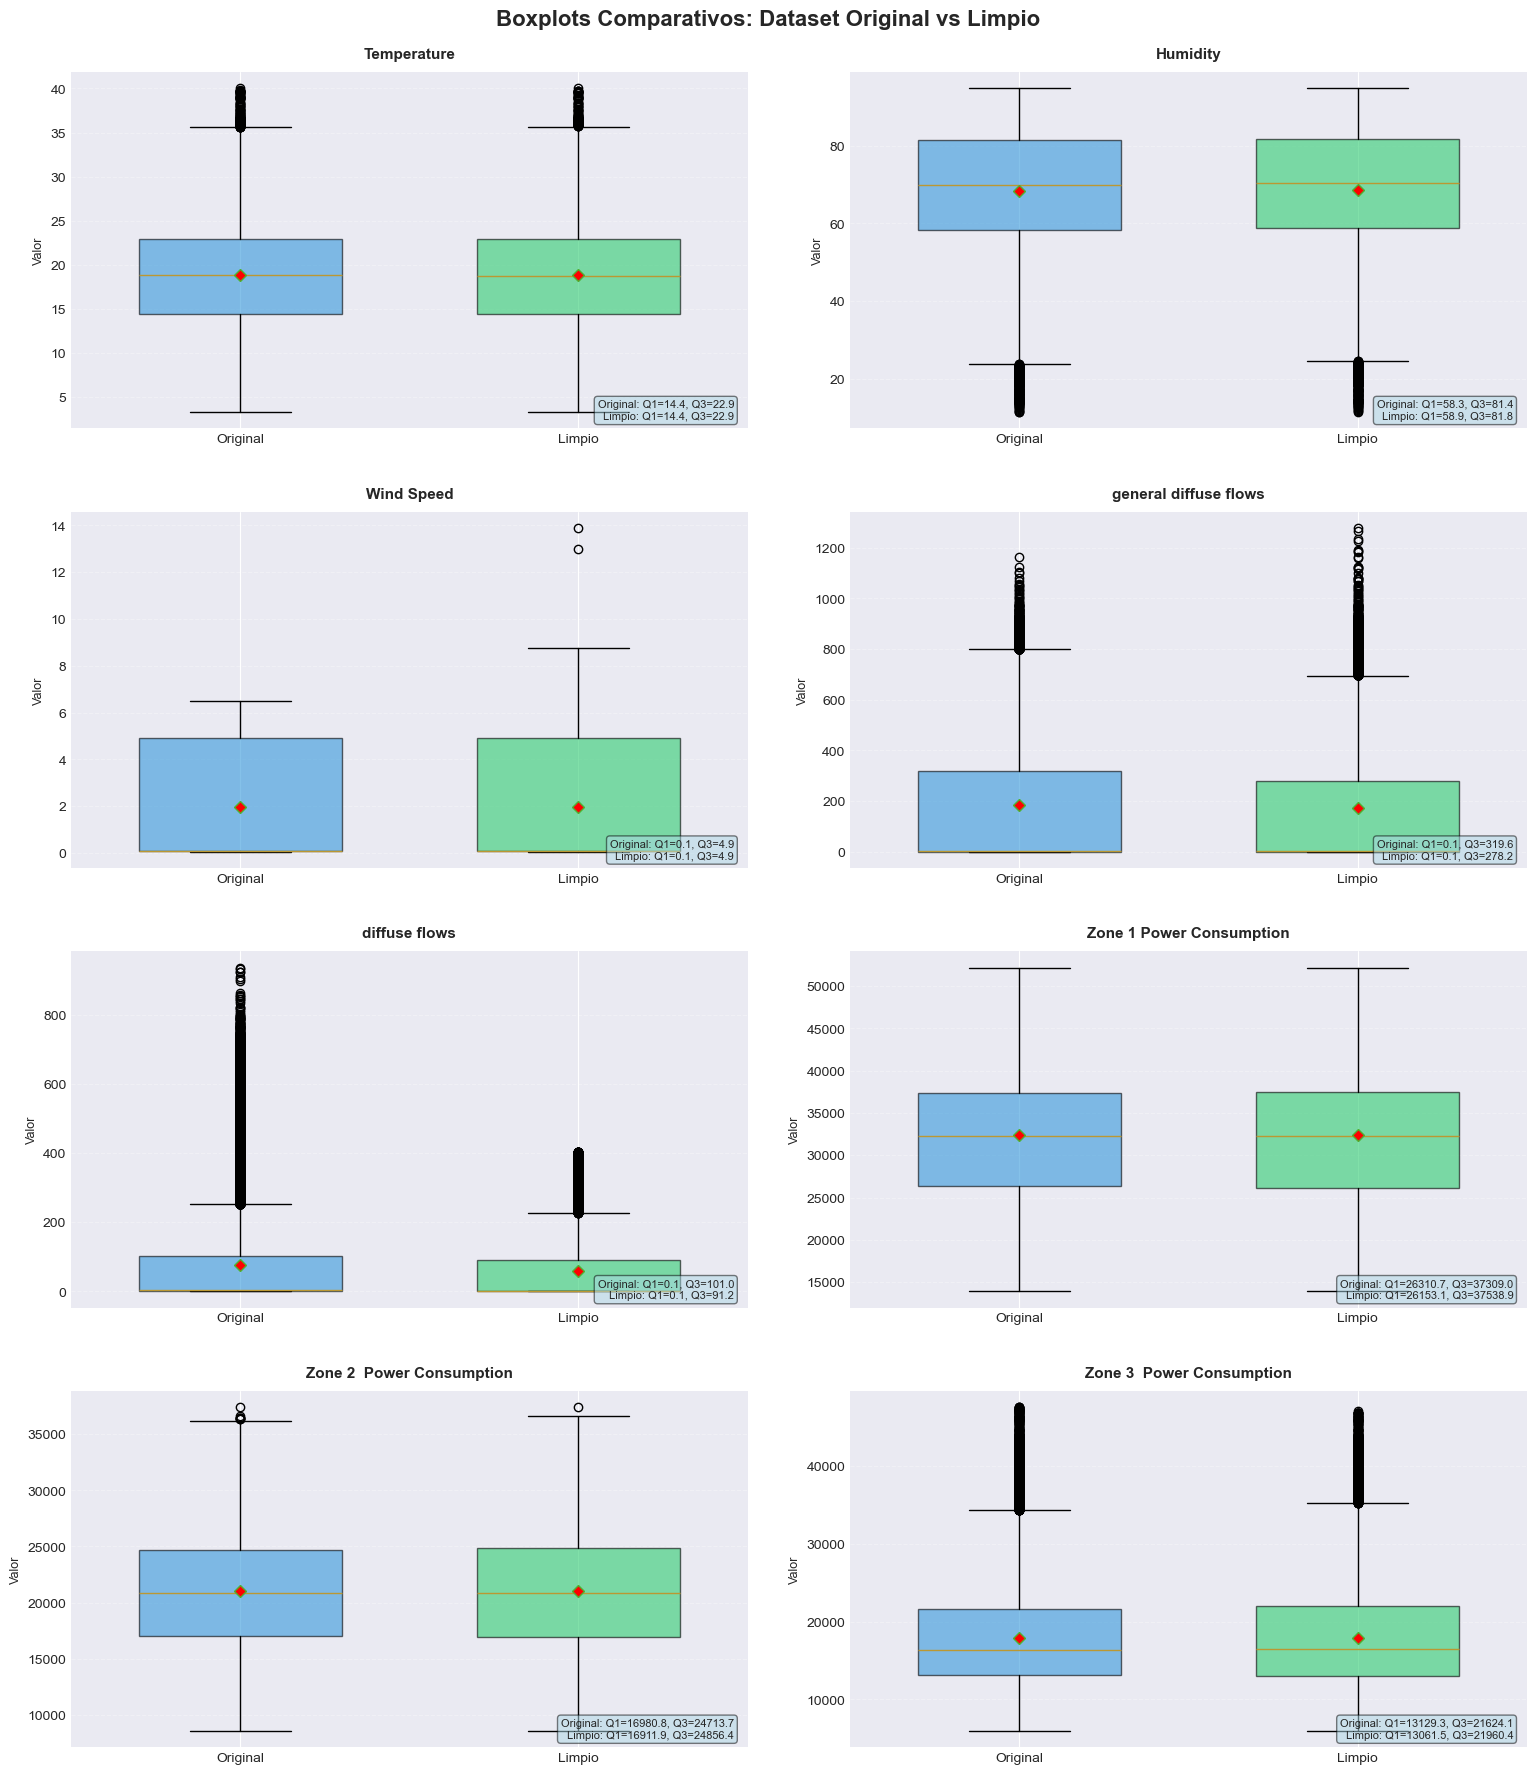

In [37]:
# GRÁFICO 2: Boxplots comparativos
fig, axes = plt.subplots(4, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, col in enumerate(columnas_numericas):
    ax = axes[idx]
    
    datos_original = df_original_numeric[col].dropna()
    datos_limpio = df_clean[col].dropna()
    
    bp = ax.boxplot([datos_original, datos_limpio], 
                 tick_labels=['Original', 'Limpio'],
                 patch_artist=True,
                 widths=0.6,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=6))
    
    bp['boxes'][0].set_facecolor(color_original)
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor(color_limpio)
    bp['boxes'][1].set_alpha(0.6)
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold', pad=10)
    ax.set_ylabel('Valor', fontsize=9)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    q1_orig, q3_orig = datos_original.quantile([0.25, 0.75])
    q1_limp, q3_limp = datos_limpio.quantile([0.25, 0.75])
    
    textstr = f'Original: Q1={q1_orig:.1f}, Q3={q3_orig:.1f}\nLimpio: Q1={q1_limp:.1f}, Q3={q3_limp:.1f}'
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout(pad=3.0)
plt.suptitle('Boxplots Comparativos: Dataset Original vs Limpio', 
             fontsize=16, fontweight='bold', y=0.998)
# plt.savefig('boxplots_original_vs_limpio.png', dpi=300, bbox_inches='tight')
# print("Boxplots guardados como 'boxplots_original_vs_limpio.png'")
plt.show()

## Modelo Var

In [38]:
warnings.filterwarnings("ignore")

def encontrar_mejor_var(dataframe_series, lags, n_splits=5):

    best_score = float('inf')
    best_lag = 0

    print(f"Iniciando búsqueda del mejor rezago")

    for p in range(lags):
        scores = []
        
        tscv = TimeSeriesSplit(n_splits=n_splits)

        try:
            for train_index, test_index in tscv.split(dataframe_series):
                train_data = dataframe_series.iloc[train_index]
                test_data = dataframe_series.iloc[test_index]

                if len(train_data) < p:
                    continue
                    
                model = VAR(train_data)
                model_fit = model.fit(maxlags=p)
                
                lag_order = model_fit.k_ar
                forecast_input = train_data.values[-lag_order:]
                predictions = model_fit.forecast(y=forecast_input, steps=len(test_data))
                
                error = mean_squared_error(test_data.values, predictions)
                scores.append(error)

            mean_score = np.mean(scores)
            
            if mean_score < best_score:
                best_score = mean_score
                best_lag = p
                print(f"  -> Nuevo mejor rezago encontrado: {p} con RMSE = {np.sqrt(best_score):.4f}")

        except Exception as e:
            # print(f"    Rezago {p} falló: {e}")
            continue
    
    print("\nBúsqueda finalizada.")
#    print(f"Mejor número de rezagos (p): {best_lag}")
#    print(f"Mejor RMSE de Cross-Validation: {np.sqrt(best_score):.4f}")

    print("Entrenando modelo final con todos los datos...")
    final_model = VAR(dataframe_series)
    final_model_fit = final_model.fit(maxlags=best_lag)
    
    return final_model_fit, best_lag, np.sqrt(best_score)

In [39]:
train, test = train_test_split(df_clean, test_size=0.05, shuffle=False)

In [40]:
mejor_modelo_var, mejor_rezago, mejor_rmse = encontrar_mejor_var(
    dataframe_series=train,
    lags=10,
    n_splits=5
)

print("\n--- Resumen del Mejor Modelo VAR Final ---")

forecast_input_final = train.values[-mejor_rezago:]
prediccion_futura = mejor_modelo_var.forecast(y=forecast_input_final, steps=10)

df_prediccion = pd.DataFrame(
    prediccion_futura, 
    index=pd.date_range(start=train.index[-1] + pd.Timedelta(minutes=10), periods=10, freq='10min'),
    columns=train.columns
)

print("\n--- Predicción multivariada para los próximos 10 días ---")

Iniciando búsqueda del mejor rezago
  -> Nuevo mejor rezago encontrado: 1 con RMSE = 4183.8604
  -> Nuevo mejor rezago encontrado: 2 con RMSE = 4168.5385
  -> Nuevo mejor rezago encontrado: 3 con RMSE = 4165.3201
  -> Nuevo mejor rezago encontrado: 4 con RMSE = 4163.5559
  -> Nuevo mejor rezago encontrado: 5 con RMSE = 4161.2701
  -> Nuevo mejor rezago encontrado: 6 con RMSE = 4159.2963
  -> Nuevo mejor rezago encontrado: 7 con RMSE = 4158.2928
  -> Nuevo mejor rezago encontrado: 8 con RMSE = 4156.9761
  -> Nuevo mejor rezago encontrado: 9 con RMSE = 4155.6913

Búsqueda finalizada.
Entrenando modelo final con todos los datos...

--- Resumen del Mejor Modelo VAR Final ---

--- Predicción multivariada para los próximos 10 días ---


In [41]:
rmse_var_1 = np.sqrt(mean_squared_error(test[:10]['Zone 1 Power Consumption'], df_prediccion['Zone 1 Power Consumption']))
rmse_var_2 = np.sqrt(mean_squared_error(test[:10]['Zone 2  Power Consumption'], df_prediccion['Zone 2  Power Consumption']))
rmse_var_3 = np.sqrt(mean_squared_error(test[:10]['Zone 3  Power Consumption'], df_prediccion['Zone 3  Power Consumption']))

print(f"Resultados de la métrica para Zona 1:")
print(f"RMSE: {rmse_var_1:.4f}")

print(f"Resultados de la métrica para Zona 2:")
print(f"RMSE: {rmse_var_2:.4f}")

print(f"Resultados de la métrica para Zona 3:")
print(f"RMSE: {rmse_var_3:.4f}")

Resultados de la métrica para Zona 1:
RMSE: 3015.0460
Resultados de la métrica para Zona 2:
RMSE: 2316.9545
Resultados de la métrica para Zona 3:
RMSE: 1024.2912


## Modelo XG Boost

In [42]:
def crear_caracteristicas_alta_frecuencia(df, variable_objetivo):
    df_copy = df.copy()
    
    df_copy['hora'] = df_copy.index.hour
    df_copy['minuto'] = df_copy.index.minute
    df_copy['dia_de_semana'] = df_copy.index.dayofweek
    df_copy['dia_del_ano'] = df_copy.index.dayofyear
    
    pasos_por_hora = 6
    pasos_por_dia = 24 * pasos_por_hora

    df_copy[f'lag_{variable_objetivo}_1_hora'] = df_copy[variable_objetivo].shift(pasos_por_hora)
    df_copy[f'lag_{variable_objetivo}_24_horas'] = df_copy[variable_objetivo].shift(pasos_por_dia)

    df_copy[f'rolling_mean_{variable_objetivo}_1_hora'] = df_copy[variable_objetivo].shift(1).rolling(window=pasos_por_hora).mean()
    df_copy[f'rolling_mean_{variable_objetivo}_24_horas'] = df_copy[variable_objetivo].shift(1).rolling(window=pasos_por_dia).mean()
    
    df_copy = df_copy.dropna()
    
    X = df_copy.drop(columns=[variable_objetivo])
    y = df_copy[variable_objetivo]
    
    return X, y

In [43]:
def encontrar_mejor_xgboost_random(dataframe, variable_objetivo, param_dist, n_iter, n_splits=5):

    X, y = crear_caracteristicas_alta_frecuencia(dataframe, variable_objetivo)
    
    modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_jobs=-1, random_state=42)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    random_search = RandomizedSearchCV(
        estimator=modelo_xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        random_state=1234
    )
    
    print(f"3. Iniciando la búsqueda aleatoria... (Probando {n_iter} combinaciones)")
    random_search.fit(X, y)
    
    print("\nBúsqueda finalizada.")
    
    best_score_rmse = -random_search.best_score_
    print(f"Mejor RMSE de Cross-Validation: {best_score_rmse:.4f}")

    best_model = random_search.best_estimator_
    
    return best_model, best_score_rmse

In [44]:
  param_distribuciones = {
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }

In [45]:
def predecir_multiples_pasos_xgboost(modelo, df_historico, n_pasos, variable_objetivo, feature_creation_func):

    df_recursivo = df_historico.copy()
    predicciones = []

    for i in range(n_pasos):
        datos_para_features = df_recursivo.tail(200)
        X_nuevas, _ = feature_creation_func(datos_para_features, variable_objetivo)
        X_a_predecir = X_nuevas.tail(1)
        
        prediccion_actual = modelo.predict(X_a_predecir)[0]
        predicciones.append(prediccion_actual)
        
        ultima_fecha_real = df_recursivo.index[-1]
        siguiente_fecha = ultima_fecha_real + pd.Timedelta(minutes=10)
        
        nueva_fila = {}
        nueva_fila[variable_objetivo] = prediccion_actual
        for col in df_recursivo.columns:
            if col != variable_objetivo:
                nueva_fila[col] = df_recursivo[col].iloc[-1]
        
        df_nueva_fila = pd.DataFrame([nueva_fila], index=[siguiente_fecha])
        df_recursivo = pd.concat([df_recursivo, df_nueva_fila])

    fechas_prediccion = pd.date_range(start=df_historico.index[-1] + pd.Timedelta(minutes=10), periods=n_pasos, freq='10T')
    serie_predicciones = pd.Series(predicciones, index=fechas_prediccion, name='predicciones_futuras')
    
    return serie_predicciones


In [46]:
mejor_modelo_random_1, mejor_rmse_random_1 = encontrar_mejor_xgboost_random(
        dataframe=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 1 Power Consumption']],
        variable_objetivo='Zone 1 Power Consumption',
        param_dist=param_distribuciones,
        n_iter=20
    )

3. Iniciando la búsqueda aleatoria... (Probando 20 combinaciones)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Búsqueda finalizada.
Mejor RMSE de Cross-Validation: 1546.9256


In [47]:
predicciones_futuras_1 = predecir_multiples_pasos_xgboost(
    modelo=mejor_modelo_random_1,
    df_historico=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 1 Power Consumption']],
    n_pasos=10,
    variable_objetivo='Zone 1 Power Consumption',
    feature_creation_func=crear_caracteristicas_alta_frecuencia
)

print("\n-----------------------------------------")
print("Predicción Final para los próximos 10 pasos:")
print(predicciones_futuras_1)
print("-----------------------------------------")


-----------------------------------------
Predicción Final para los próximos 10 pasos:
2017-12-13 12:50:00    32576.937500
2017-12-13 13:00:00    32395.621094
2017-12-13 13:10:00    32033.185547
2017-12-13 13:20:00    32016.992188
2017-12-13 13:30:00    31945.541016
2017-12-13 13:40:00    31913.830078
2017-12-13 13:50:00    31871.142578
2017-12-13 14:00:00    31782.039062
2017-12-13 14:10:00    31479.070312
2017-12-13 14:20:00    31459.808594
Freq: 10min, Name: predicciones_futuras, dtype: float32
-----------------------------------------


In [48]:
mejor_modelo_random_2, mejor_rmse_random_2 = encontrar_mejor_xgboost_random(
        dataframe=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 2  Power Consumption']],
        variable_objetivo='Zone 2  Power Consumption',
        param_dist=param_distribuciones,
        n_iter=20
    )

3. Iniciando la búsqueda aleatoria... (Probando 20 combinaciones)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Búsqueda finalizada.
Mejor RMSE de Cross-Validation: 1101.5479


In [49]:
predicciones_futuras_2 = predecir_multiples_pasos_xgboost(
    modelo=mejor_modelo_random_2,
    df_historico=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 2  Power Consumption']],
    n_pasos=10,
    variable_objetivo='Zone 2  Power Consumption',
    feature_creation_func=crear_caracteristicas_alta_frecuencia
)

print("\n-----------------------------------------")
print("Predicción Final para los próximos 10 pasos:")
print(predicciones_futuras_2)
print("-----------------------------------------")


-----------------------------------------
Predicción Final para los próximos 10 pasos:
2017-12-13 12:50:00    26545.042969
2017-12-13 13:00:00    26607.613281
2017-12-13 13:10:00    26836.287109
2017-12-13 13:20:00    27119.652344
2017-12-13 13:30:00    27113.875000
2017-12-13 13:40:00    27074.208984
2017-12-13 13:50:00    27050.019531
2017-12-13 14:00:00    27012.871094
2017-12-13 14:10:00    26856.796875
2017-12-13 14:20:00    26960.289062
Freq: 10min, Name: predicciones_futuras, dtype: float32
-----------------------------------------


In [50]:
mejor_modelo_random_3, mejor_rmse_random_3 = encontrar_mejor_xgboost_random(
        dataframe=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 3  Power Consumption']],
        variable_objetivo='Zone 3  Power Consumption',
        param_dist=param_distribuciones,
        n_iter=20
    )

3. Iniciando la búsqueda aleatoria... (Probando 20 combinaciones)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Búsqueda finalizada.
Mejor RMSE de Cross-Validation: 1730.5629


In [51]:
predicciones_futuras_3 = predecir_multiples_pasos_xgboost(
    modelo=mejor_modelo_random_3,
    df_historico=train[['Temperature','Humidity','Wind Speed','general diffuse flows','diffuse flows','Zone 3  Power Consumption']],
    n_pasos=10,
    variable_objetivo='Zone 3  Power Consumption',
    feature_creation_func=crear_caracteristicas_alta_frecuencia
)

print("\n-----------------------------------------")
print("Predicción Final para los próximos 10 pasos:")
print(predicciones_futuras_3)
print("-----------------------------------------")


-----------------------------------------
Predicción Final para los próximos 10 pasos:
2017-12-13 12:50:00    9664.998047
2017-12-13 13:00:00    9551.095703
2017-12-13 13:10:00    9619.388672
2017-12-13 13:20:00    9593.555664
2017-12-13 13:30:00    9671.599609
2017-12-13 13:40:00    9671.599609
2017-12-13 13:50:00    9867.939453
2017-12-13 14:00:00    9837.370117
2017-12-13 14:10:00    9884.333008
2017-12-13 14:20:00    9884.333008
Freq: 10min, Name: predicciones_futuras, dtype: float32
-----------------------------------------


## Comparativo de Modelos

In [52]:
rmse_xgb_1 = np.sqrt(mean_squared_error(test[:10]['Zone 1 Power Consumption'], predicciones_futuras_1))
rmse_xgb_2 = np.sqrt(mean_squared_error(test[:10]['Zone 2  Power Consumption'], predicciones_futuras_2))
rmse_xgb_3 = np.sqrt(mean_squared_error(test[:10]['Zone 3  Power Consumption'],  predicciones_futuras_3))

print(f"Resultados de la métrica para Zona 1:")
print(f"RMSE: {rmse_xgb_1:.4f}")

print(f"Resultados de la métrica para Zona 2:")
print(f"RMSE: {rmse_xgb_2:.4f}")

print(f"Resultados de la métrica para Zona 3:")
print(f"RMSE: {rmse_xgb_3:.4f}")

Resultados de la métrica para Zona 1:
RMSE: 278.9662
Resultados de la métrica para Zona 2:
RMSE: 1625.5182
Resultados de la métrica para Zona 3:
RMSE: 688.4826


In [53]:
rmse_var_1 = np.sqrt(mean_squared_error(test[:10]['Zone 1 Power Consumption'], df_prediccion['Zone 1 Power Consumption']))
rmse_var_2 = np.sqrt(mean_squared_error(test[:10]['Zone 2  Power Consumption'], df_prediccion['Zone 2  Power Consumption']))
rmse_var_3 = np.sqrt(mean_squared_error(test[:10]['Zone 3  Power Consumption'], df_prediccion['Zone 3  Power Consumption']))

print(f"Resultados de la métrica para Zona 1:")
print(f"RMSE: {rmse_var_1:.4f}")

print(f"Resultados de la métrica para Zona 2:")
print(f"RMSE: {rmse_var_2:.4f}")

print(f"Resultados de la métrica para Zona 3:")
print(f"RMSE: {rmse_var_3:.4f}")

Resultados de la métrica para Zona 1:
RMSE: 3015.0460
Resultados de la métrica para Zona 2:
RMSE: 2316.9545
Resultados de la métrica para Zona 3:
RMSE: 1024.2912
